## ch19 Exploring SHAP
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.10</div>
<div style="text-align: right"> Last update: 2023.8.10</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

### 19.1 SHAP

SHAP은 분류 모델과 회귀 모델 모두에서 작동합니다. 
SHAP은 모델과 모델을 통한 예측을 분석하여 예제의 모든 특징에 대한 값을 출력합니다. 
이 값은 게임 이론을 사용하여 결정되며, 타겟에 대한 특징 간의 기여도를 분배하는 방법을 나타냅니다.  
분류의 경우, 이 값은 양성 레이블의 로그 확률에 합산됩니다.  
(회귀의 경우, SHAP 값은 타겟 예측에 합산됩니다.)  

SHAP 알고리즘의 주요 장점 중 하나는 모델의 내부 작동을 알 수 있는 화이트박스 모델과 모델의 내부 작동을 알 수 없는 블랙박스 모델 모두에 대한 설명을 제공할 수 있다는 것입니다.  
또한 복잡한 모델과 기능 간의 상호 작용을 처리할 수 있으며 다양한 설정에서 정확하고 일관된 설명을 제공하는 것으로 나타났습니다. 

단계별 튜닝 모델에 이 라이브러리를 사용하는 방법을 살펴 보겠습니다.  
이 라이브러리는 Python과 함께 제공되지 않으므로 반드시 설치해야 합니다.

In [9]:
step_params = {'random_state': 42,
'max_depth': 5,
'min_child_weight': 0.6411044640540848,
'subsample': 0.9492383155577023,
'colsample_bytree': 0.6235721099295888,
'gamma': 0.00011273797329538491,
'learning_rate': 0.24399020050740935}
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50, n_estimators=500)

xg_step.fit(X_train, y_train,
            eval_set=[(X_train, y_train),
                      (X_test, y_test)])

[0]	validation_0-logloss:0.64342	validation_1-logloss:0.64282
[1]	validation_0-logloss:0.61194	validation_1-logloss:0.61365
[2]	validation_0-logloss:0.58526	validation_1-logloss:0.58554
[3]	validation_0-logloss:0.56425	validation_1-logloss:0.56696
[4]	validation_0-logloss:0.55033	validation_1-logloss:0.55494
[5]	validation_0-logloss:0.54046	validation_1-logloss:0.54843
[6]	validation_0-logloss:0.53313	validation_1-logloss:0.54342
[7]	validation_0-logloss:0.52095	validation_1-logloss:0.53473
[8]	validation_0-logloss:0.51609	validation_1-logloss:0.53200
[9]	validation_0-logloss:0.51066	validation_1-logloss:0.52768
[10]	validation_0-logloss:0.50507	validation_1-logloss:0.52554
[11]	validation_0-logloss:0.49716	validation_1-logloss:0.52216
[12]	validation_0-logloss:0.49074	validation_1-logloss:0.51730
[13]	validation_0-logloss:0.48567	validation_1-logloss:0.51452
[14]	validation_0-logloss:0.48295	validation_1-logloss:0.51371
[15]	validation_0-logloss:0.47896	validation_1-logloss:0.51415
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6235721099295888, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00011273797329538491, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.24399020050740935, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.6411044640540848, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

셰이프 라이브러리는 주피터에서 잘 작동합니다. 
일부 상호작용을 허용하는 자바스크립트 시각화를 제공합니다. 
자바스크립트 확장을 활성화하려면 initjs 함수를 실행해야 합니다.

그런 다음 TreeExplainer의 인스턴스를 생성합니다. 
이 인스턴스는 SHAP 값을 제공할 수 있습니다. 
TreeExplainer 인스턴스는 호출 가능하며 설명 객체를 반환합니다. 
이 객체에는 각 샘플의 모든 기능에 대한 SHAP 값이 포함된 .values 속성이 있습니다.

In [10]:
import shap

shap.initjs()

shap_ex = shap.TreeExplainer(xg_step)
vals = shap_ex(X_test)

In [11]:
vals

.values =
array([[ 0.4266138 ,  0.39018407, -0.24635297, ...,  0.01400568,
        -0.01346467,  0.10417715],
       [ 0.01116392, -0.13114417, -0.29213503, ..., -0.06415682,
        -0.02604112,  0.06993142],
       [-0.21806298, -0.14070478, -0.41129303, ...,  0.01691866,
        -0.0269322 , -0.59192175],
       ...,
       [ 0.0791291 , -0.09577084,  1.1367989 , ..., -0.08004596,
        -0.0660319 ,  0.10197484],
       [-0.20658436,  0.43007442, -0.3851001 , ..., -0.04810803,
        -0.00718523,  0.09319562],
       [ 0.00735102,  0.5893515 ,  1.485712  , ..., -0.15941103,
        -0.06738751,  0.12656035]], dtype=float32)

.base_values =
array([-0.21742104, -0.21742104, -0.21742104, -0.21742104, -0.21742104,
       -0.21742104, -0.21742104, -0.21742104, -0.21742104, -0.21742104,
       -0.21742104, -0.21742104, -0.21742104, -0.21742104, -0.21742104,
       -0.21742104, -0.21742104, -0.21742104, -0.21742104, -0.21742104,
       -0.21742104, -0.21742104, -0.21742104, -0.21742104,

In [12]:
shap_df = pd.DataFrame(vals.values, columns=X_test.columns)
shap_df

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
0,0.426614,0.390184,-0.246353,0.145825,-0.034680,0.379261,-0.019017,0.004868,0.000877,0.002111,0.0,0.033738,-0.117918,-0.018271,0.369876,0.014006,-0.013465,0.104177
1,0.011164,-0.131144,-0.292135,-0.014521,0.016003,-1.043464,0.020524,0.039019,0.047712,0.001010,0.0,0.068171,0.086444,-0.026271,-0.428484,-0.064157,-0.026041,0.069931
2,-0.218063,-0.140705,-0.411293,0.048281,0.424516,0.487451,-0.098703,-0.004710,0.063545,0.000258,0.0,0.005533,-0.105534,-0.010548,-0.333695,0.016919,-0.026932,-0.591922
3,-0.015227,-0.299068,-0.426323,-0.205840,-0.125867,0.320594,-0.062712,0.019110,0.012257,0.002184,0.0,-0.000044,0.042814,-0.024099,0.486864,0.038438,-0.013727,0.047564
4,-0.468785,-0.200953,-0.230639,0.064272,0.021362,0.355619,-0.083344,-0.017202,0.002754,0.001432,0.0,0.035772,-0.073206,-0.022188,0.324419,0.012664,-0.019550,0.093926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,0.268237,-0.112710,0.330096,-0.209942,0.012074,-1.144335,-0.065815,0.028274,0.032291,0.001012,0.0,-0.086408,0.136677,0.310404,-0.407444,-0.013195,-0.026412,-0.484734
901,0.154642,0.572190,-0.227121,0.448253,-0.057847,0.290381,-0.069114,0.006243,0.007443,0.002198,0.0,-0.074364,0.115520,-0.008244,0.602087,0.039680,-0.012820,0.083934
902,0.079129,-0.095771,1.136799,0.150705,0.133260,0.484103,-0.120819,0.012034,0.057516,0.000266,0.0,0.103810,-0.097848,0.003234,-0.313785,-0.080046,-0.066032,0.101975
903,-0.206584,0.430074,-0.385100,-0.078808,-0.083052,-0.992487,-0.088811,0.080561,0.028648,0.000876,0.0,0.045213,0.066553,-0.031448,-0.524141,-0.048108,-0.007185,0.093196


각 raw 값과.base_values를 더하면 log odd 값을 얻게 된다. 샘플이 양수라는?    

If you add up each row and add the .base_values attribute (this is the default guess for the
model) you will get the log odds value that the sample is in the positive case. I will stick the
sum in a dataframe with the column name pred. I will also include the ground truth value and
convert the log odds sum into a probability column, prob. If the probability is above .5 (this
happens when pred is positive), we predict the positive value.

In [13]:
(pd.concat([shap_df.sum(axis = "columns").rename('pred') + vals.base_values,
           pd.Series(y_test, name = 'true')], axis = 'columns')
 .assign(prob = lambda adf: (np.exp(adf.pred)/ (1 + np.exp(adf.pred))))
)

,pred,true,prob
0,1.204413,1,0.769309
1,-1.883659,0,0.131969
2,-1.113024,0,0.247308
3,-0.420504,1,0.396396
4,-0.421070,1,0.396261
...,...,...,...
900,-1.649352,0,0.161197
901,1.655642,0,0.839652
902,1.271108,0,0.780932
903,-1.918025,0,0.128082


- 3, 4, 902 번째 row는 잘못된 예측을 했음을 알 수 있다.

### 19.2 Examining a Single Prediction

In [14]:
X_test.iloc[0]

age                            22.0
education                      16.0
years_exp                       1.0
compensation                    0.0
python                          1.0
r                               0.0
sql                             0.0
Q1_Male                         1.0
Q1_Female                       0.0
Q1_Prefer not to say            0.0
Q1_Prefer to self-describe      0.0
Q3_United States of America     0.0
Q3_India                        1.0
Q3_China                        0.0
major_cs                        1.0
major_other                     0.0
major_eng                       0.0
major_stat                      0.0
Name: 7894, dtype: float64

In [15]:
xg_step.predict(X_test.iloc[[0]])

array([1])

In [16]:
y_test[0]

1

In [17]:
shap_ex.expected_value

-0.21742104

- shap의 expected value가 0보다 작다 따라서 디펄트가 data scientist 이다.

In [18]:
shap_ex.expected_value + vals.values[0].sum()

1.204413

- 1보다 커졌기 때문에 이 샘플에 대해서는 소프트웨어 엔지니어로 예측한다.

### 19.3 Waterfall Plots

waterfall 플롯은 단일 입력에 대한 설명을 제공함   
아래 그림을 보면 버티컬 라인이 -0.21에 위치하고 있다.  
베이스 value가 -0.21라는 의미이다. 
그리고 디펄트로 데이터사이언티스트로 예측하고 있다는 의미이다.   


The waterfall plot is rank ordered. The feature with the most impact is shown at the top.
The next most important feature is second, and so on. The age value of 22 gave a SHAP value
of 0.43. This pushes the result towards the positive case. The R value, 0.0, also pushes toward
the positive case with a magnitude of 0.38. We repeat this and see that the values add up to
1.204 (in the upper right). (You can confirm this from our addition above.)

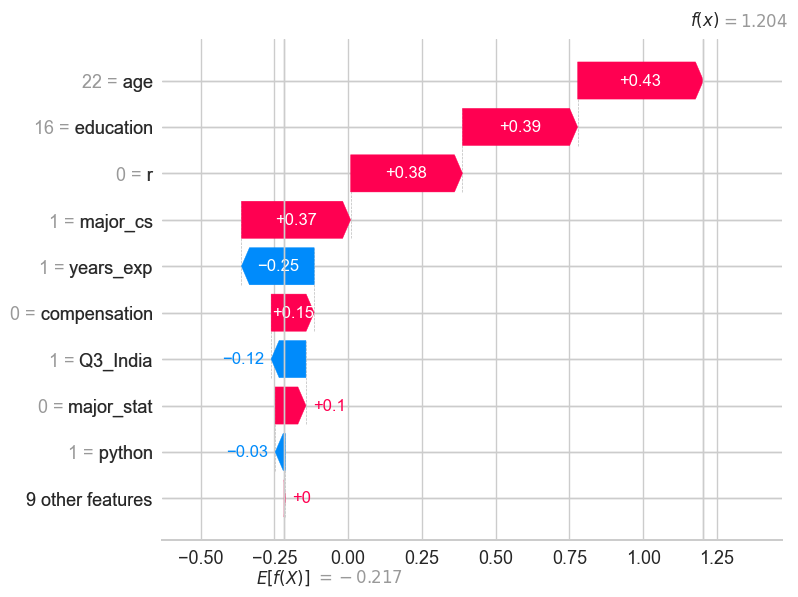

In [19]:
#fig = plt.figure(figsize = (8, 4))
shap.plots.waterfall(vals[0], show = False)

이 샘플이 얼ㅁ나 다른 샘플과 연관되어 있는지 확인하기 위해 히스토그램을 그려보자.

In [20]:
def plot_histograms(df, columns, row=None, title='', color='shap'):
    """
    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to plot histograms for.
    columns : list of str
        The names of the columns to plot histograms for.
    row : pandas.Series, optional
        A row of data to plot a vertical line for.
    title : str, optional
        The title to use for the figure.
    color : str, optional
        'shap' - color positive values red. Negative blue
        'mean' - above mean red. Below blue.
        None - black

    Returns
    -------
    matplotlib.figure.Figure
        The figure object containing the histogram plots.    
    """
    red = '#ff0051'
    blue = '#008bfb'

    fig, ax = plt.subplots(figsize=(8, 4))
    hist = (df
     [columns]
     .hist(ax=ax, color='#bbb')
    )
    fig = hist[0][0].get_figure()
    if row is not None:
        name2ax = {ax.get_title():ax for ax in fig.axes}
        pos, neg = red, blue
        if color is None:
            pos, neg = 'black', 'black'
        for column in columns:
            if color == 'mean':
                mid = df[column].mean()
            else:
                mid = 0
            if row[column] > mid:
                c = pos
            else:
                c = neg
            name2ax[column].axvline(row[column], c=c)
    fig.tight_layout()
    fig.suptitle(title)
    return fig

해당 샘플이 각 데이터 분포에서 어느 지점에 위치하고 있는지 보여준다.

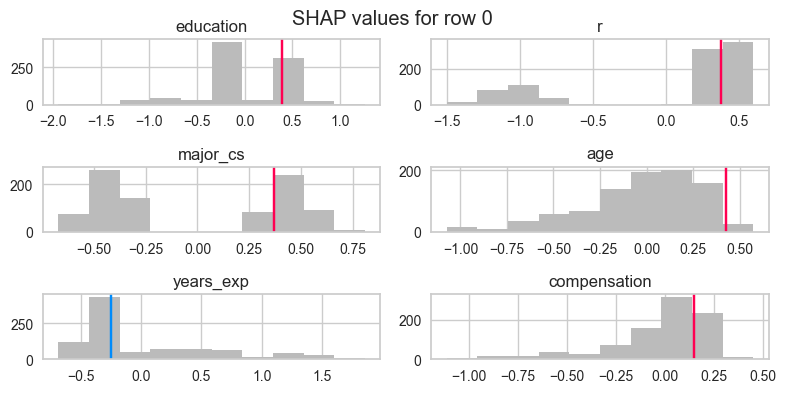

In [21]:
features = ['education', 'r', 'major_cs', 'age', 'years_exp',
'compensation']
fig = plot_histograms(shap_df, features, shap_df.iloc[0],
title='SHAP values for row 0')
fig

원본 데이터에 적용해보자.

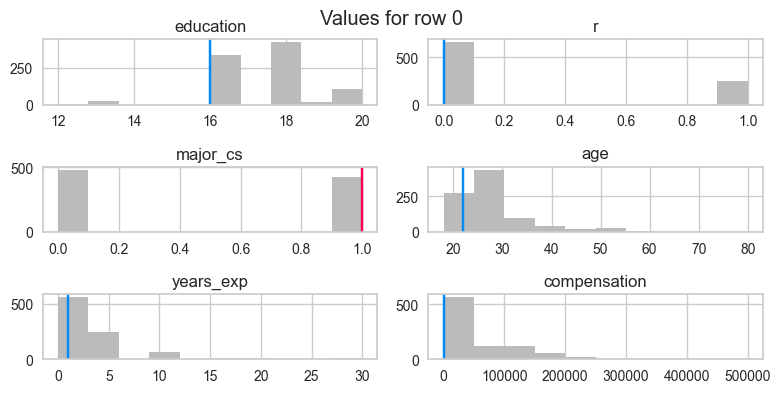

In [22]:
fig = plot_histograms(X_test, features, X_test.iloc[0],
title='Values for row 0', color='mean')
fig

shap value에 대한 바플롯을 그려보자.

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(vals.values[0], index=X_test.columns)
.sort_values(key=np.abs)
.plot.barh(ax=ax)
)

<Axes: >

### 19.4 A Force Plot

flattened version of the waterfall plot이다.

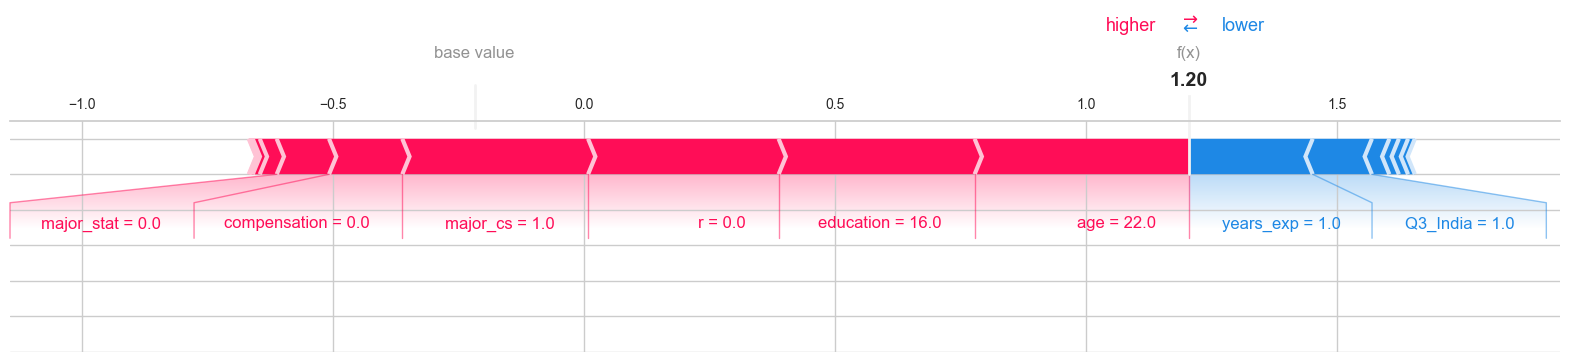

In [24]:
res = shap.plots.force(base_value=vals.base_values,
shap_values=vals.values[0,:], features=X_test.iloc[0],
matplotlib=True, show=False
)
res

### 19.5 Force Plot with Multiple Predictions

In [25]:
# First n values
n = 100
# blue - DS
# red - Software Engineer
shap.plots.force(base_value=vals.base_values,
shap_values=vals.values[:n,:], features=X_test.iloc[:n],
)

### 19.6 Understanding Features with Dependence Plots

shap value를 각 샘플에 대해서 구할 수 있기 때문에 feature importance 처럼 사용할 수 있다.

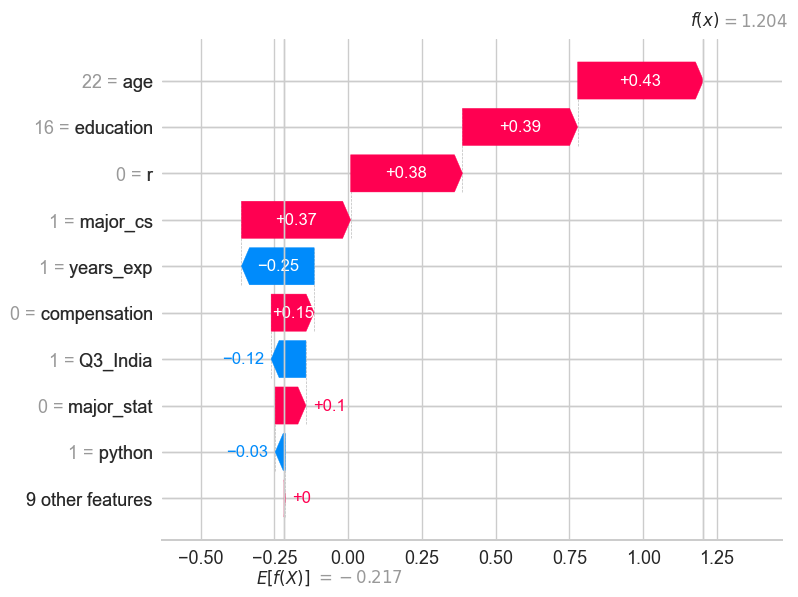

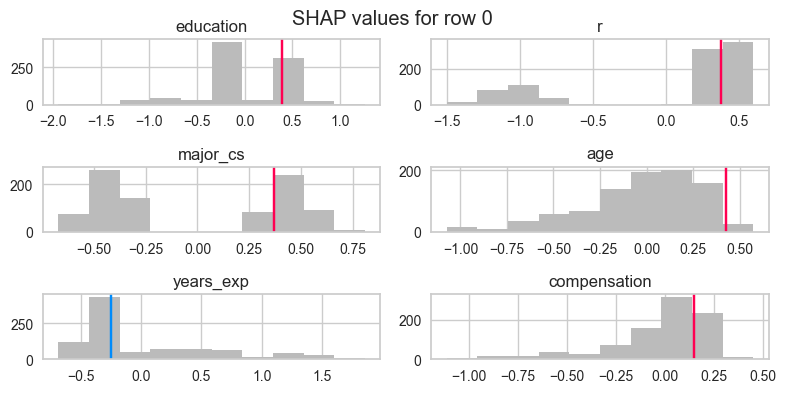

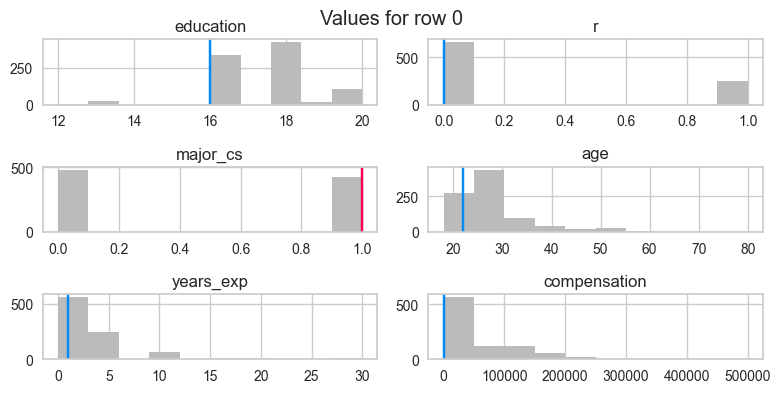

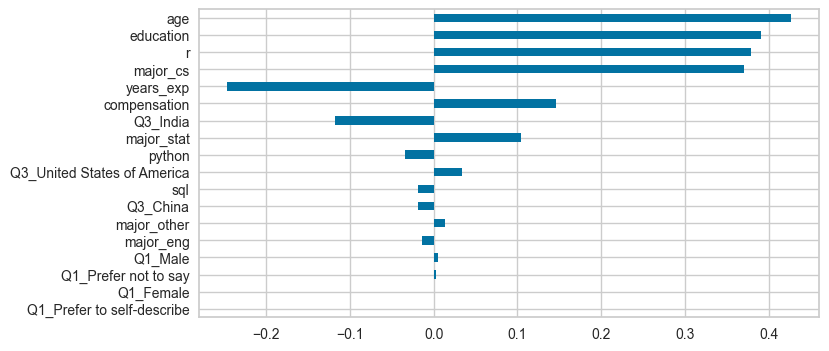

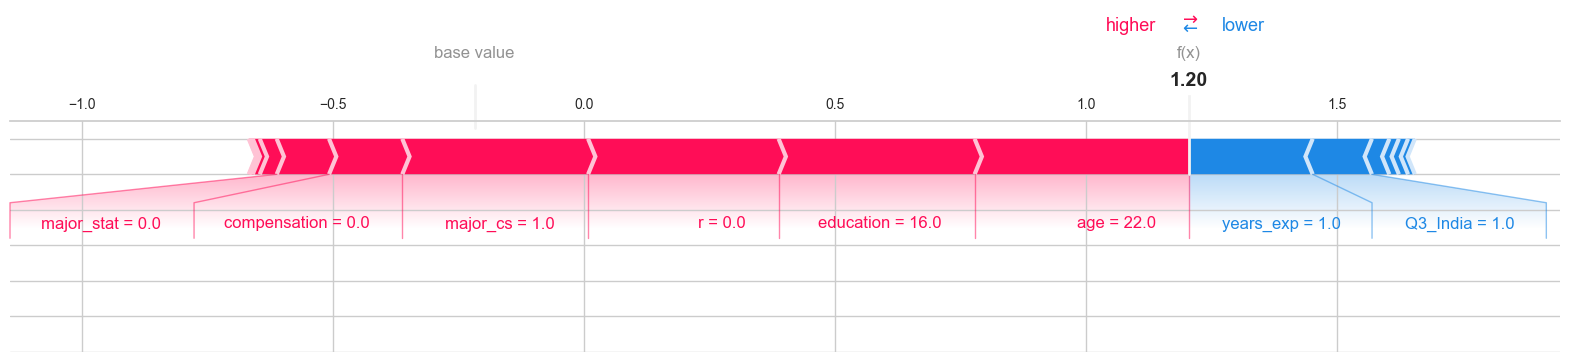

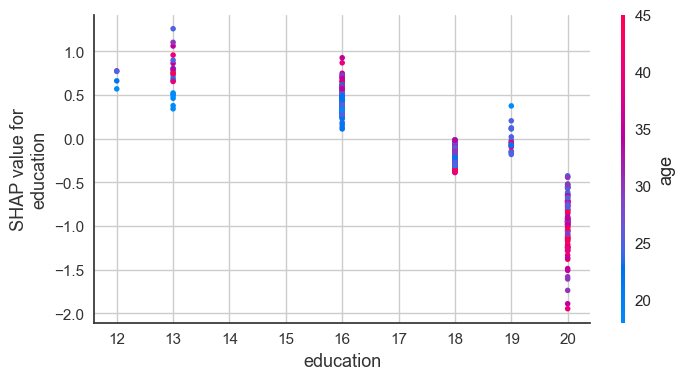

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'education'], ax=ax, color=vals, 
                   x_jitter=0, hist=False)

다시 볼 것

Let’s try and make sense of this plot. In the x-axis, we have different entries for education.
In the y-axis, we have the different SHAP values for each education value. You might wonder
why the y values are different. This is because the education column interacts with other
columns, so sometimes a value of 19 pushes toward Data Scientist, and sometimes it moves
towards Software Engineer. Remember that y values above 0 will push toward the positive
label, and negative values push toward the negative label. My interpretation of this plot is
that there is a non-linear relationship between education and the target. Education values
push towards the negative label quicker as the value increases.
Here are a couple of other things to note about this plot. The shap library automatically
chooses an interaction index, another column to plot in a color gradient. In this example, it
decided on the age feature. This allows you to visualize how another column interacts with
education. It is a little hard to see, but higher compensation pushes more toward the software
engineer label for low education levels. You can specify a different column by setting the color
parameter to a single column of values (color=vals[:, 'compensation'])).

### 19.7 Jittering a Dependence Plot

생략

### 19.8 Heatmaps and Correlations

shap value의 상관성을 살펴보자.

우선 shap를 고려하지 않고 상관도를 그려보자.

In [27]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(X_test
.assign(software_eng=y_test)
.corr(method='spearman')
.loc[:, ['age', 'education', 'years_exp',
'compensation', 'r', 'major_cs',
'software_eng']],
cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)

<Axes: >

이 히트맵은 피처가 같은 방향 또는 반대 방향으로 움직이는 경향이 있는지 알려줍니다. 예측과 상관관계가 있는지 확인하기 위해 software_eng 열을 추가했습니다.

이제 각 예측에 대한 SHAP 값의 상관 관계에 대한 히트 맵을 만들겠습니다. 이 상관관계를 통해 두 특징이 예측을 유사하게 움직이는 경향이 있는지 알 수 있습니다. 예를 들어, 교육과 전공 통계의 SHAP 값은 모두 예측 레이블을 같은 방향으로 밀어냅니다. 이는 서로 다른 관점에서 상호작용을 이해하는 데 도움이 될 수 있습니다.

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(shap_df       
            .assign(software_eng=y_test)
            .corr(method='spearman')
            .loc[:, ['age', 'education', 'years_exp',  'compensation', 'r', 'major_cs',
                     'software_eng']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)

<Axes: >

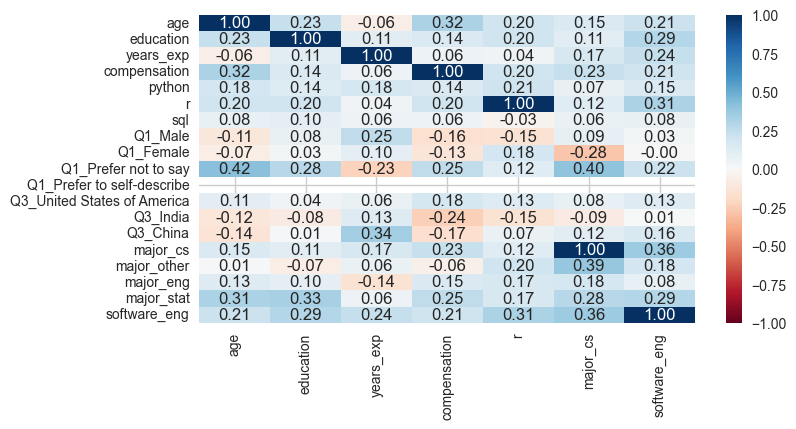

In [29]:
fig

Generally, when dealing with correlation heatmaps, I want to look at the dark red and
dark blue values (ignoring the self-correlation values). It looks like the SHAP values for
compensation tend to rise if the SHAP values for age rise. (Note that this is different from
the actual non-SHAP values correlating, though, in the case of compensation and age, it looks
like they do.) You could explore these further by doing a scatter plot.

### 19.9 Beeswarm Plots of Global Behavior

SHAP은 로컬 예측 및 피처 상호 작용을 설명할 뿐만 아니라 피처가 모델에 미치는 영향에 대한 글로벌 뷰를 제공한다.
beeswarm or summary plot을 살펴보자. 여기에는 최종 예측에 가장 큰 영향을 미치는 특징이 순위별로 나열되어 있습니다. X축에는 SHAP 값이 있습니다.   

값이 양수일수록 양수 레이블을 향해 밀게된다.  
각 피처는 높은(빨간색) 또는 낮은(파란색) 값을 나타내기 위해 색상이 지정됩니다.   
R 피처는 빨간색과 파란색 값만 있는 이진입니다. 값(1)이 높으면 데이터 과학을 향해 크게 밀려나는 것을 볼 수 있습니다.  
빨간색 값의 확산은 다른 열과의 상호 작용을 나타냅니다.  
이를 이해하는 또 다른 방법은 R이 빨간색일 때 모델에 큰 영향을 미치는 낮은 빈도 효과가 있을 수 있다는 것입니다.

years_exp 피처에는 여러 옵션이 있기 때문에 색상에 그라데이션이 있습니다.   
파란색에서 빨간색으로 매우 부드럽게 전환되는 것처럼 보입니다.  
이 부드러운 그라데이션을 왼쪽에서 빨간색, 보라색, 다시 빨간색, 파란색으로 바뀌는 education과 대조해 보십시오.  
이는 education 피처의 동작이 단조롭지 않음을 나타냅니다.  
위의 education에 대한 의존성 플롯에서 이를 확인할 수 있습니다.

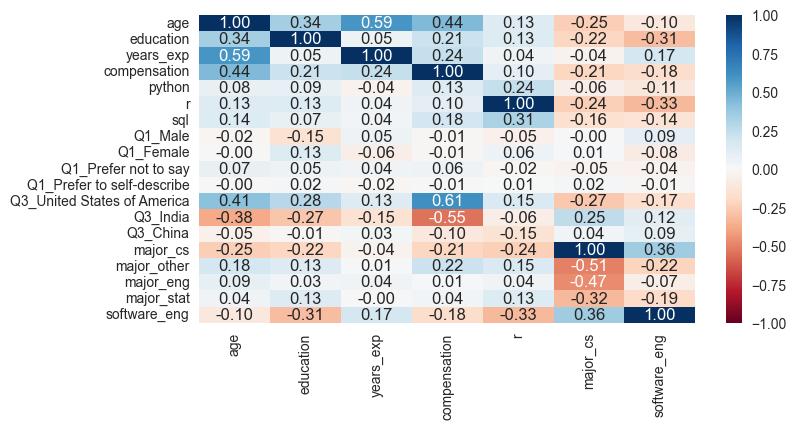

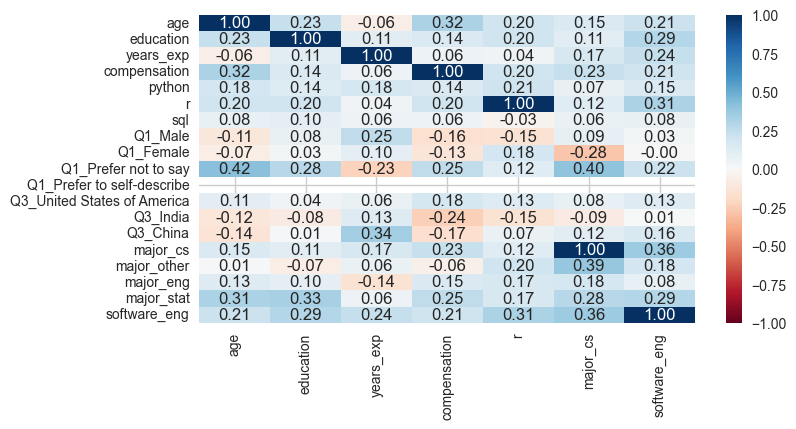

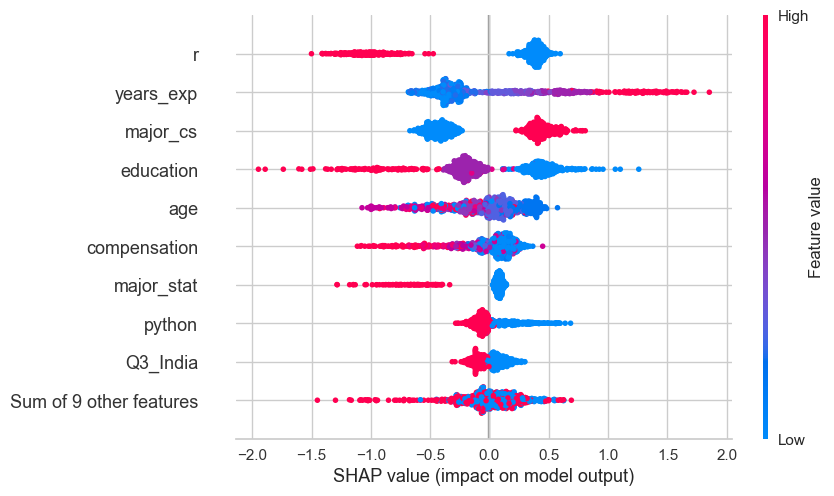

In [30]:
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals)

- 모든 피처를 보려면 max_display 매개변수를 사용하세요.  
그리고 컬러맵을 회색조에서 더 잘 작동하는 Matplotlib 컬러맵으로 변경하고 있습니다.???

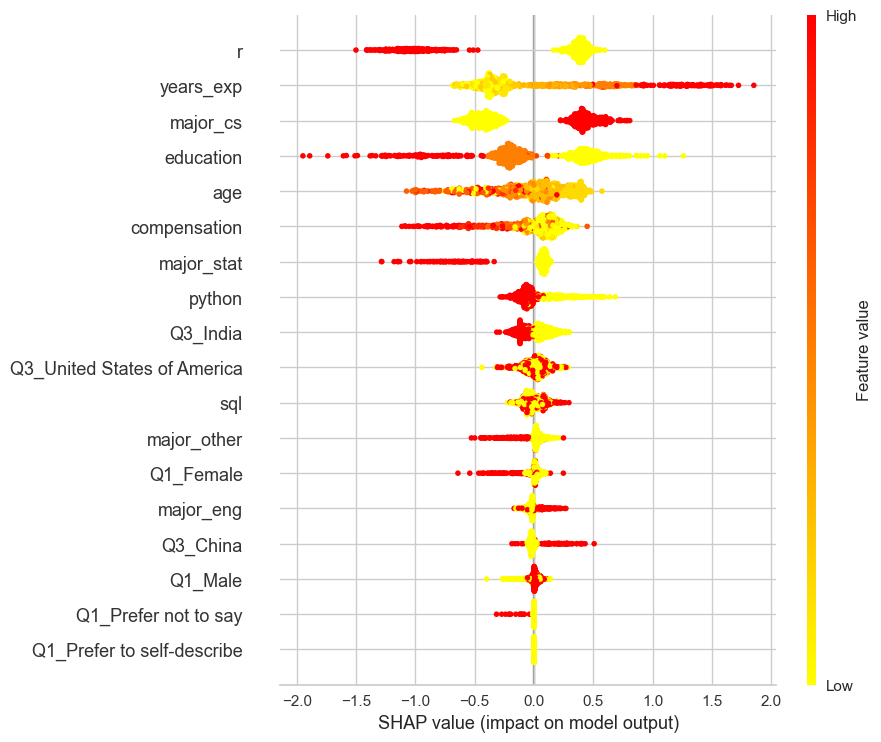

In [31]:
from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals, max_display=len(X_test.columns), color=cm.autumn_r)

### 19.10 SHAP with No Interaction

모델에 상호 작용이 있는 경우 SHAP 값에 반영됩니다.  
상호작용을 제거하면 최대 깊이를 1로 설정하여 모델을 단순화할 수 있습니다.  
또한 비선형 반응을 더 명확하게 표현할 수 있습니다.  
그루터기 모델을 훈련하고 몇 가지 SHAP 플롯을 살펴봅시다.

In [32]:
no_int_params = {'random_state': 42,
'max_depth': 1
}
xg_no_int = xgb.XGBClassifier(**no_int_params, early_stopping_rounds=50,
n_estimators=500)

In [33]:
xg_no_int.fit(X_train, y_train,
eval_set=[(X_train, y_train),
(X_test, y_test)
]
)

[0]	validation_0-logloss:0.66369	validation_1-logloss:0.66482
[1]	validation_0-logloss:0.64011	validation_1-logloss:0.63808
[2]	validation_0-logloss:0.62727	validation_1-logloss:0.62572
[3]	validation_0-logloss:0.61616	validation_1-logloss:0.61161
[4]	validation_0-logloss:0.60677	validation_1-logloss:0.60019
[5]	validation_0-logloss:0.59976	validation_1-logloss:0.59271
[6]	validation_0-logloss:0.59367	validation_1-logloss:0.58586
[7]	validation_0-logloss:0.58825	validation_1-logloss:0.58060
[8]	validation_0-logloss:0.58343	validation_1-logloss:0.57479
[9]	validation_0-logloss:0.57913	validation_1-logloss:0.57104
[10]	validation_0-logloss:0.57524	validation_1-logloss:0.56556
[11]	validation_0-logloss:0.57190	validation_1-logloss:0.56135
[12]	validation_0-logloss:0.56887	validation_1-logloss:0.55773
[13]	validation_0-logloss:0.56617	validation_1-logloss:0.55407
[14]	validation_0-logloss:0.56377	validation_1-logloss:0.55167
[15]	validation_0-logloss:0.56138	validation_1-logloss:0.54892
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [34]:
xg_no_int.score(X_test, y_test)

0.7370165745856354

In [35]:
shap_ind = shap.TreeExplainer(xg_no_int)
shap_ind_vals = shap_ind(X_test)

이제 상호작용이 없는 summary plot을 그려보자.

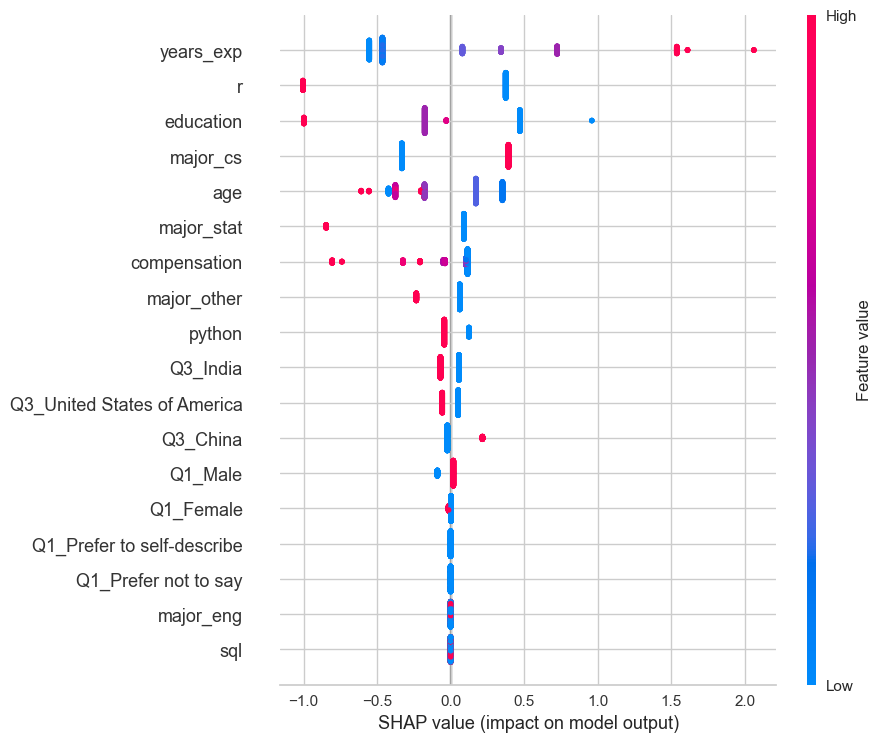

In [36]:
from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(shap_ind_vals, max_display=len(X_test.columns))

이 모델에서 기능 중요도의 순서가 변경되는 것을 관찰하는 것은 흥미롭습니다. 다음은 상호 작용이 있는 모델에 대한 years_exp 플롯입니다. 다른 열과 years_exp의 상호 작용으로 인해 y축에 수직으로 퍼져 있는 것을 볼 수 있습니다. (x축의 확산은 지터링으로 인한 것입니다.)

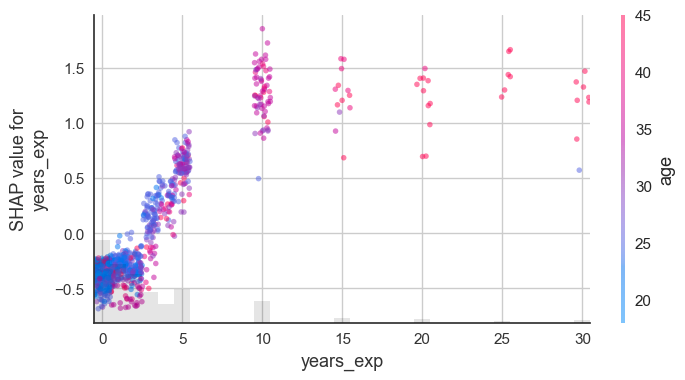

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'years_exp'], ax=ax,
color=vals[:, 'age'], alpha=.5,
x_jitter=1)

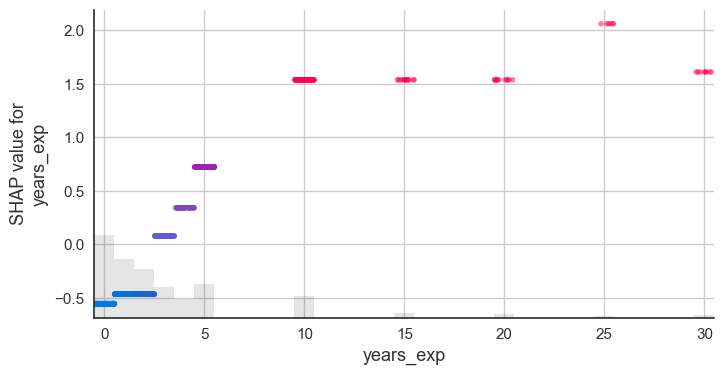

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(shap_ind_vals[:, 'years_exp'], ax=ax,
color=shap_ind_vals[:, 'age'], alpha=.5,
x_jitter=1)

 - 이렇게 하면 years_exp의 비선형 응답이 매우 명확해집니다. 
 - population density를 표시하는데 도움이 되도록 이 y축에 지터를 적용하고 싶을 수 있지만 shap은 이를 지원하지 않습니다.  
 - 알파 매개변수를 변경하여 밀도를 나타낼 수 있습니다.